# Ex. 2. Convolutional neural network for traﬃc sign recognition 
### Template provided by Christian Igel, 2020


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import pathlib
import os

print("TensorFlow version:", tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version: 2.2.0-rc4


### Ex. 2.1.
#### Add batch normalization to the model using tf.keras.layers. BatchNormalization. Please show in the report all places where you added it (include the layer before and after for each batch normalization layer). 


I added the batch normalization before each rectified linear unit activation function. See the code below when the model is defined.

### Code

Download the data:

In [0]:
data_root="."
tf.keras.utils.get_file("GTSRB.zip",
                        "https://sid.erda.dk/share_redirect/EB0rrpZwuI",
                        cache_dir=data_root,
                        extract=True)


'./datasets/GTSRB.zip'

The images are stored in subdirectories. The names of the subdirectories encode the class labels. 

In [0]:
# Determine the number of training and test images
n_train = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/train/*/*")))
n_test = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/test/*/*")))

print("Number of training images:", n_train)
print("Number of test images:" ,n_test)

Number of training images: 39209
Number of test images: 12630


Some basic constants: 

In [0]:
no_classes = 43 
no_channels = 3 

# All images are initially resized to img_height x img_width
img_height  = 32  
img_width   = 32
# During training and testing the images are cropped to img_height_crop x img_width_crop
img_height_crop = 28  
img_width_crop  = 28

batch_size = 128
steps_per_epoch = n_train // batch_size  

Helper function for extracting the label information from the paths to the images and loading and preprocessing the images:

In [0]:
# Extract the label from the file path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.strings.to_number(parts[-2], tf.int32)

# Load image, convert it to floats, and resize it
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=no_channels)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

# Given the path and filename of an image, create the label and the input image
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Create data sets based on the files:

In [0]:
# Tell dataset the lists of files containing the trainig and test images, respectively
list_ds_train = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/train/*/*")
list_ds_test  = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/test/*/*", shuffle=False)  # Fixed order for test time augemantation 

# Tell dataset how to extract images and labels
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE) # num of parallel processing depends on the CPU core
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

Functions for data preprocessing/augmentation:

In [0]:
# Used for training data augmentation
def augment(image, label):
    # Take a random sub-image 28x28 from the input
    image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
    # Only for the defines labels, random flip the image
    image = tf.case([(tf.equal(label, 11), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 12), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 13), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 17), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 18), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 26), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 30), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 35), lambda: tf.image.random_flip_left_right(image))], default = lambda: image)
    # Change the brightness (sometimes brighter, sometimes darker)
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    # Clip all values from 0 and 1, so that they are the values of a proper image
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

# Used for testing/evaluation
def crop_center(image, label):
  # I take the center of the image 28x28
  image = tf.image.resize_with_crop_or_pad(image, img_height_crop, img_width_crop)
  return image, label

# Could be used for test time augementation
def crop_random(image, label):
  image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
  return image, label

We prepare the data for training and testing differently. For example, for training we use data augmentation.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):         
      ds = ds.cache(cache)             
    else:
      ds = ds.cache()  
  # We shuffle the data after the caching
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
  # Repeat forever
  ds = ds.repeat()                     
  # Do data augmentation
  ds = ds.map(augment, num_parallel_calls=AUTOTUNE) 
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_evaluation(ds, shuffle_buffer_size=1000):
  # For normal evaluation, we look at the center of the image
  ds = ds.map(crop_center, num_parallel_calls=AUTOTUNE)         
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_augmented_evaluation(ds):
  ds = ds.map(crop_random, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

Let's have a look at a random batch of images:



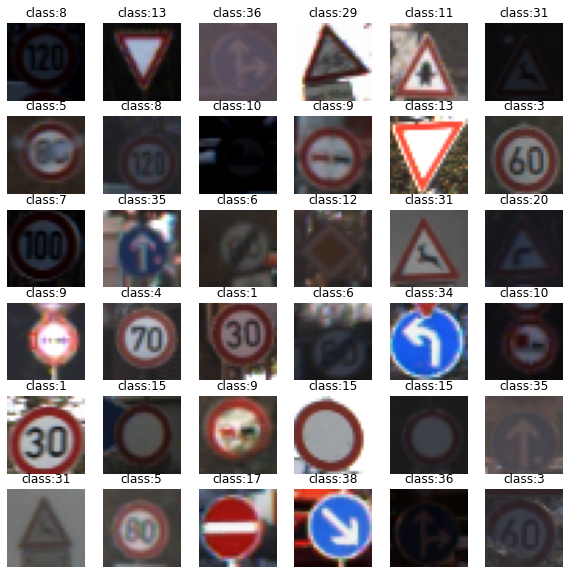

In [0]:
# Helper function for displaying images
def show_batch(image_batch, label_batch, nrows=6, ncols=6):
  plt.figure(figsize=(10,10))
  for n in range(nrows*ncols):
      ax = plt.subplot(nrows, ncols, n+1)
      if no_channels == 3:
        plt.imshow(image_batch[n])
      else:
        plt.imshow(image_batch[n].reshape([img_height_crop, img_width_crop]))
      plt.title('class:' + str(label_batch[n]))
      plt.axis('off')
      
# Make training dataset 
train_ds = prepare_for_training(labeled_ds_train)

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Visualize images and labels
show_batch(image_batch.numpy(), label_batch.numpy())

Model provided in the template

In [0]:
sd_init = 0.01  

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, no_channels),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.BatchNormalization(), # Batch normalization added here
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.BatchNormalization(), # Batch normalization added here
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(no_classes, activation='softmax')])
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
elu_4 (ELU)                  (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
elu_5 (ELU)                  (None, 8, 8, 64)         

Define optimizer and compile the model:

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
original.compile(loss='sparse_categorical_crossentropy', optimizer=opt, 
               metrics=['accuracy']) 

Do the learning:

In [0]:
# Train the model
import time
start = time.time()

history_original = original.fit(train_ds, epochs=800, steps_per_epoch=steps_per_epoch)

print("Training took", (time.time() - start)/60, "minutes.")

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/800
306/306 [==============================] - 16s 53ms/step - loss: 3.5897 - accuracy: 0.0616
Epoch 2/800
306/306 [==============================] - 4s 14ms/step - loss: 3.4129 - accuracy: 0.1466
Epoch 3/800
306/306 [==============================] - 5s 15ms/step - loss: 3.1630 - accuracy: 0.2149
Epoch 4/800
306/306 [==============================] - 4s 14ms/step - loss: 2.7053 - accuracy: 0.3226
Epoch 5/800
306/306 [==============================] - 4s 14ms/step - loss: 2.2569 - accuracy: 0.4024
Epoch 6/800
306/306 [==============================] - 4s 13ms/step - loss: 1.9159 - accuracy: 0.4802
Epoch 7/800
306/306 [==============================] - 4s 13ms/step - loss: 1.6544 - accuracy: 0.5457
Epoch 8/800
306/306 [==============================] - 4s 13ms/step - loss: 1.4645 - accuracy: 0.5994
Epoch 9/800
306/306 [==============================] - 4s 13ms/step - loss: 1.3090 - accuracy: 0.6461
Epoch 10/800
306/306 [==============================] - 4s 14ms/step - loss: 1.17

KeyboardInterrupt: ignored

Let's evaluate the model:

In [0]:
eval_train_ds = prepare_for_evaluation(labeled_ds_train)
eval_test_ds = prepare_for_evaluation(labeled_ds_test)

# Evaluate the model
results_train = original.evaluate(eval_train_ds)
print('Train loss, train acc original model:', results_train)
results_test = original.evaluate(eval_test_ds)
print('Test loss, test acc original model:', results_test)